In [1]:
!pip install numpy pandas librosa tqdm resampy joblib audiomentations tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.1/260.1 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 79.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.4/113.4 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 117.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 113.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 120.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.4 MB/s eta 0:00:00
  Attempting uninstall: librosa
    Found existing ins

In [3]:
!pip install imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 6.2 MB/s eta 0:00:00


In [37]:
#For data preprocessing and preparation
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from packaging import version
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

#for Model and its evaluation
from keras.models import Sequential, Model
from keras.layers import Input, LSTM, Bidirectional, Dense, Dropout, Layer
from keras.layers import Conv1D, MaxPooling1D, BatchNormalization, GlobalAveragePooling1D
from keras import backend as K
from tensorflow.keras.optimizers import Adam
from keras.layers import Attention
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping

# DATA Preprocessing and Preparation

In [5]:
emotion_dict = {
    "01": "neutral", "02": "calm", "03": "happy", "04": "sad",
    "05": "angry", "06": "fearful", "07": "disgust", "08": "surprised"
}

In [6]:
def parse_emotion(file_name):
    code = file_name.split("-")[2]
    return emotion_dict.get(code, "unknown")

def gather_file_paths(root_dirs):
    collected = []
    for root_dir in root_dirs:
        for root, _, files in os.walk(root_dir):
            for file in files:
                if file.endswith('.wav'):
                    full_path = os.path.join(root, file)
                    label = parse_emotion(file)
                    collected.append((full_path, label))
    return pd.DataFrame(collected, columns=["filepath", "emotion"])

In [7]:
def extract_mfcc_feature(path, duration=3, offset=0.5, n_mfcc=40):
    try:
        y, sr = librosa.load(path, duration=duration, offset=offset)
        mfcc_feat = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        return np.mean(mfcc_feat.T, axis=0)
    except Exception as e:
        print(f"Failed to process {path}: {e}")
        return None

In [10]:
paths_df = gather_file_paths(["/content/drive/MyDrive/MaRS/dataset/Audio_Speech_Actors_01-24", "/content/drive/MyDrive/MaRS/dataset/Audio_Song_Actors_01-24"])
features, labels = [], []
for i, row in paths_df.iterrows():
    mfcc_vector = extract_mfcc_feature(row['filepath'])
    if mfcc_vector is not None:
        features.append(mfcc_vector)
        labels.append(row['emotion'])

X = np.array(features)
y = np.array(labels)

In [12]:
joblib.dump((X, y), '/content/drive/MyDrive/MaRS/models/cached_features.pkl')

['/content/drive/MyDrive/MaRS/models/cached_features.pkl']

In [13]:
X, y = joblib.load('/content/drive/MyDrive/MaRS/models/cached_features.pkl')

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [15]:
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

In [40]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train_resampled)
y_test_encoded = le.transform(y_test)

joblib.dump(le, "/content/drive/MyDrive/MaRS/models/label_encoder.pkl")

print("Encoded classes:", le.classes_)

Encoded classes: ['angry' 'calm' 'disgust' 'fearful' 'happy' 'neutral' 'sad' 'surprised']


/tmp/ipython-input-16-3393665754.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train_resampled, order=pd.Series(y_train_resampled).value_counts().index, palette="cubehelix")


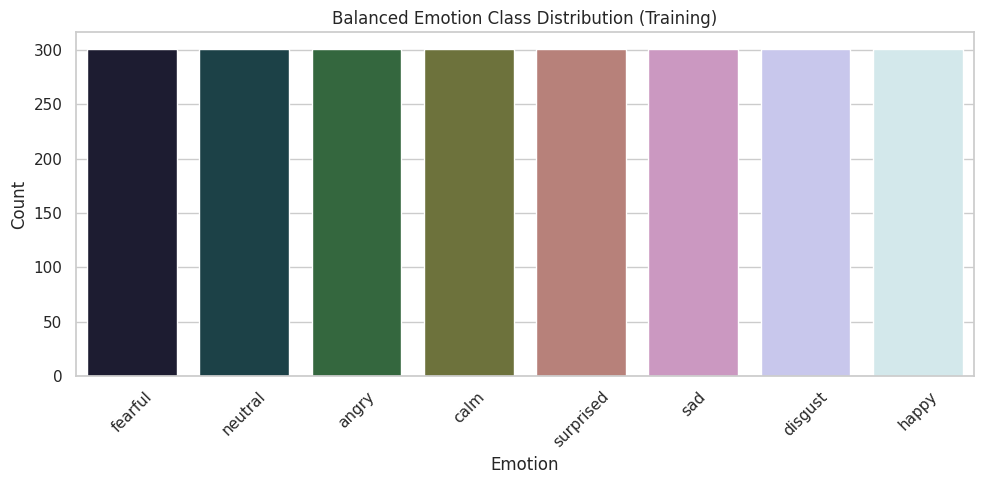

In [16]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 5))
sns.countplot(x=y_train_resampled, order=pd.Series(y_train_resampled).value_counts().index, palette="cubehelix")
plt.title("Balanced Emotion Class Distribution (Training)")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [17]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)
joblib.dump(scaler, '/content/drive/MyDrive/MaRS/models/scaler.pkl')

['/content/drive/MyDrive/MaRS/models/scaler.pkl']

In [22]:
print("Train shape:", X_train_scaled.shape)
print("Test shape:", X_test_scaled.shape)

Train shape: (2408, 40)
Test shape: (491, 40)


# Model Building

In [30]:
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight',
                                 shape=(input_shape[-1], 1),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(name='att_bias',
                                 shape=(input_shape[1], 1),
                                 initializer='zeros',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
      e = tf.tanh(tf.matmul(x, self.W) + self.b)
      e = tf.squeeze(e, axis=-1)
      alpha = tf.nn.softmax(e)
      alpha = tf.expand_dims(alpha, axis=-1)
      context = x * alpha
      context = tf.reduce_sum(context, axis=1)
      return context

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[2])

In [31]:
if len(X_train.shape) != 3:
    X_train = X_train.reshape(-1, 40, 1)
    X_test = X_test.reshape(-1, 40, 1)

In [32]:
num_classes = len(np.unique(y_train))

In [34]:
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(input_layer)
x = MaxPooling1D(2)(x)
x = BatchNormalization()(x)

x = Conv1D(128, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling1D(2)(x)
x = BatchNormalization()(x)

x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = Dropout(0.3)(x)

x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = Dropout(0.3)(x)

attn = AttentionLayer()(x)

x = Dense(128, activation='relu')(attn)
x = Dropout(0.4)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer=Adam(learning_rate=5e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 40, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 40, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 20, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 20, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 10, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ (None, 10, 256)        │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 10, 128)        │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer_3               │ (None, 128)            │           138 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 470,930 (1.80 MB)

 Trainable params: 470,546 (1.79 MB)

 Non-trainable params: 384 (1.50 KB)

In [57]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

model.compile(
    loss='sparse_categorical_crossentropy',  # ✔️ use sparse version
    optimizer='adam',
    metrics=['accuracy']
)

model.fit(
    X_train, y_train_encoded,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.9118 - loss: 0.2332 - val_accuracy: 0.6802 - val_loss: 1.2343
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9149 - loss: 0.2412 - val_accuracy: 0.7208 - val_loss: 1.1671
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9228 - loss: 0.2314 - val_accuracy: 0.7056 - val_loss: 1.1424
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.9324 - loss: 0.1960 - val_accuracy: 0.7005 - val_loss: 1.1765
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.9307 - loss: 0.1945 - val_accuracy: 0.7157 - val_loss: 1.2284
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.9235 - loss: 0.2333 - val_accuracy: 0.6954 - val_loss: 1.1263
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9413 - loss: 0.1853 - val_accuracy: 0.7360 - val_loss: 1.0562
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.9265 - loss: 0.2456 - val_accuracy: 0.7157 - 

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step

✅ Test Accuracy: 0.7291

📋 Classification Report:
              precision    recall  f1-score   support

       angry       0.86      0.76      0.81        75
        calm       0.92      0.76      0.83        75
     disgust       0.65      0.56      0.60        39
     fearful       0.62      0.73      0.67        75
       happy       0.72      0.84      0.78        75
     neutral       0.70      0.79      0.74        38
         sad       0.68      0.64      0.66        75
   surprised       0.67      0.67      0.67        39

    accuracy                           0.73       491
   macro avg       0.73      0.72      0.72       491
weighted avg       0.74      0.73      0.73       491



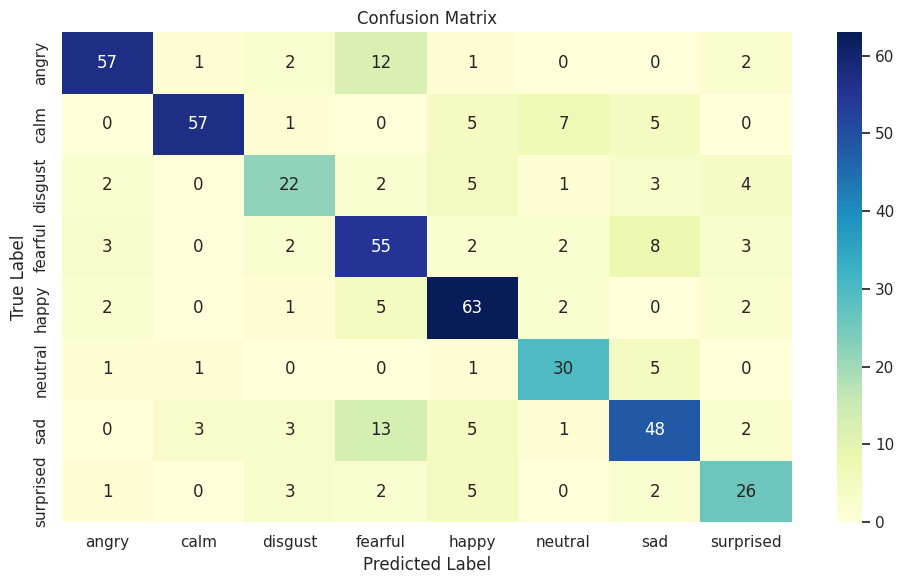

In [58]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on test set
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)  # predicted integer labels

# Accuracy
acc = accuracy_score(y_test_encoded, y_pred_labels)
print(f"\n✅ Test Accuracy: {acc:.4f}")

# Classification report
print("\n📋 Classification Report:")
print(classification_report(y_test_encoded, y_pred_labels, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test_encoded, y_pred_labels)

# Plot Confusion Matrix
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap="YlGnBu")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [59]:
model.save('/content/drive/MyDrive/MaRS/models/trained_model.h5')

In [60]:
model.save('/content/drive/MyDrive/MaRS/models/emotion_model.keras')